In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
file_path = '/content/drive/MyDrive/Freight rate prediction/data/Container_Ocean_Freight_Rates.csv'
df = pd.read_csv(file_path)

In [ ]:
import pandas as pd

events = pd.DataFrame({
    'holiday': [
        # Major Disruptions
        'Hanjin_Bankruptcy',
        'Trump_Tariffs_Start',
        'COVID',
        'Suez_Blockage',
        'Russia_Ukraine_War',
        'US_Port_Congestion',
        'Global_Reopening',
        'OPEC_Oil_Shock',
        'Red_Sea_Houthi',

        # Recurring: Chinese New Year (2016–2024)
        'Chinese_New_Year', 'Chinese_New_Year', 'Chinese_New_Year',
        'Chinese_New_Year', 'Chinese_New_Year', 'Chinese_New_Year',
        'Chinese_New_Year', 'Chinese_New_Year', 'Chinese_New_Year',

        # Recurring: Golden Week (Oct)
        'Golden_Week', 'Golden_Week', 'Golden_Week',
        'Golden_Week', 'Golden_Week', 'Golden_Week',
        'Golden_Week', 'Golden_Week', 'Golden_Week',

        # Recurring: Peak Season
        'Peak_Season', 'Peak_Season', 'Peak_Season',
        'Peak_Season', 'Peak_Season', 'Peak_Season',
        'Peak_Season', 'Peak_Season', 'Peak_Season'
    ],
    'ds': pd.to_datetime([
        # One-off Events
        '2016-08-31', '2018-03-01', '2020-03-01',
        '2021-03-23', '2022-02-24', '2021-08-01',
        '2021-06-01', '2022-10-05', '2023-12-01',

        # Chinese New Year (Estimated Mid-Jan to Mid-Feb)
        '2016-02-08', '2017-01-28', '2018-02-16',
        '2019-02-05', '2020-01-25', '2021-02-12',
        '2022-02-01', '2023-01-22', '2024-02-10',

        # Golden Week (China) - Always Oct 1
        '2016-10-01', '2017-10-01', '2018-10-01',
        '2019-10-01', '2020-10-01', '2021-10-01',
        '2022-10-01', '2023-10-01', '2024-10-01',

        # Peak Season (U.S./Europe pre-holiday rush)
        '2016-09-01', '2017-09-01', '2018-09-01',
        '2019-09-01', '2020-09-01', '2021-09-01',
        '2022-09-01', '2023-09-01', '2024-09-01'
    ]),
    'lower_window': [0] * 9 + [0] * 9 + [0] * 9 + [0] * 9,
    'upper_window': [
        60, 90, 90, 7, 90, 60, 60, 30, 30,     # Major events
        15, 15, 15, 15, 15, 15, 15, 15, 15,     # Chinese New Year
        7, 7, 7, 7, 7, 7, 7, 7, 7,              # Golden Week
        90, 90, 90, 90, 90, 90, 90, 90, 90      # Peak Season
    ]
})


In [ ]:
def run_prophet_model(df, origin, container_size, events_df, forecast_months=12, plot=True):
    df_sub = df[(df['Origin'] == origin) & (df['Container Size'] == container_size)].copy()

    # Convert to datetime format and round to month start
    df_sub['Date'] = pd.to_datetime(df_sub['Date'], errors='coerce')
    df_sub = df_sub.dropna(subset=['Date'])
    df_sub['Date'] = df_sub['Date'].dt.to_period('M').dt.to_timestamp()

    df_sub.rename(columns={'Date': 'ds', 'Rate': 'y'}, inplace=True)
    df_sub = df_sub[['ds', 'y']].sort_values('ds')

    # Train-test split
    df_train = df_sub.iloc[:-forecast_months]
    df_test = df_sub.iloc[-forecast_months:]

    model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=events_df,
    changepoint_prior_scale=0.5,   #higher = more flexibility
    seasonality_prior_scale=10,
    seasonality_mode = 'multiplicative',
    )

    model.fit(df_train)

    # Create future dates
    future = model.make_future_dataframe(periods=forecast_months, freq='MS')
    forecast = model.predict(future)

    # Plot forecast
    if plot:
        model.plot(forecast)
        plt.title(f"Forecast: {origin} + {container_size}")
        plt.show()

        model.plot_components(forecast)
        plt.show()


        merged = df_sub.set_index('ds').join(forecast.set_index('ds')[['yhat']], how='left')
        plt.plot(merged.index, merged['y'], label='Actual', color='black', linewidth=2)
        plt.plot(merged.index, merged['yhat'], label='Forecast', color='blue', linestyle='--')  # Forecast from the point it starts

        test_start = df_test.index.min()
        test_end = df_test.index.max()

        plt.title(f"Forecast vs Actual with Test Period: {origin} + {container_size}")
        plt.xlabel("Date")
        plt.ylabel("Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    # Evaluate
    forecast = forecast.set_index('ds')
    df_test = df_test.set_index('ds')

    common_dates = df_test.index.intersection(forecast.index)
    mae = mean_absolute_error(df_test.loc[common_dates]['y'], forecast.loc[common_dates]['yhat'])
    rmse = np.sqrt(mean_squared_error(df_test.loc[common_dates]['y'], forecast.loc[common_dates]['yhat']))

    print(f"\n 🔴Prophet Evaluation for {origin} + {container_size}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")



    return forecast.reset_index(), model


<ipython-input-6-62152dc2e1d5>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sub['Date'] = pd.to_datetime(df_sub['Date'], errors='coerce')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/leszvkeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/2_ypqmrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55792', 'data', 'file=/tmp/tmp_fjglatn/leszvkeo.json', 'init=/tmp/tmp_fjglatn/2_ypqmrm.json', 'output', 'file=/tmp/tmp_fjglatn/prophet_modelz61q93lb/prophet_model-20250522142928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:28 - cmdstanpy - INFO - Chain [1] done processin

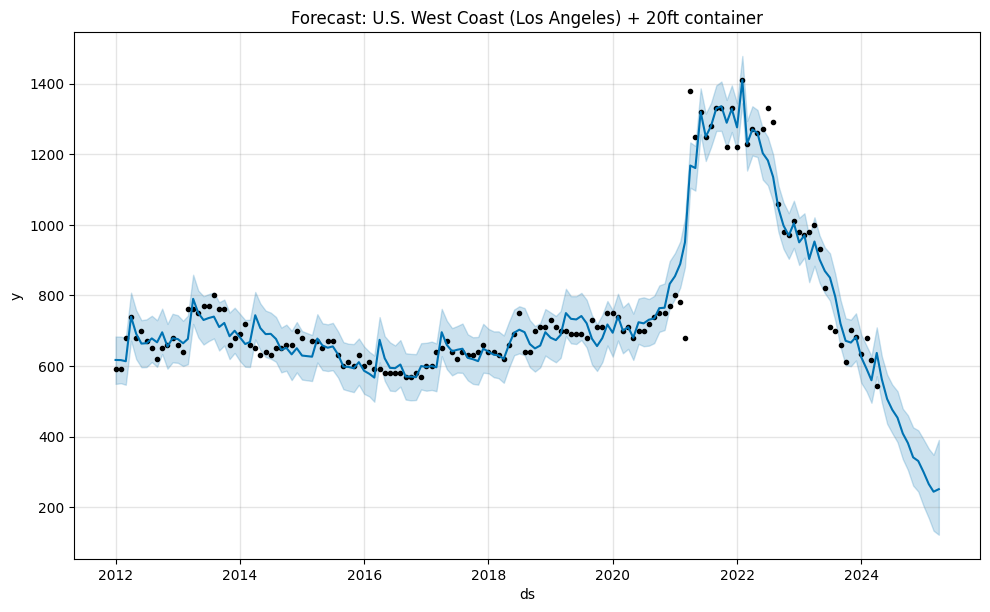

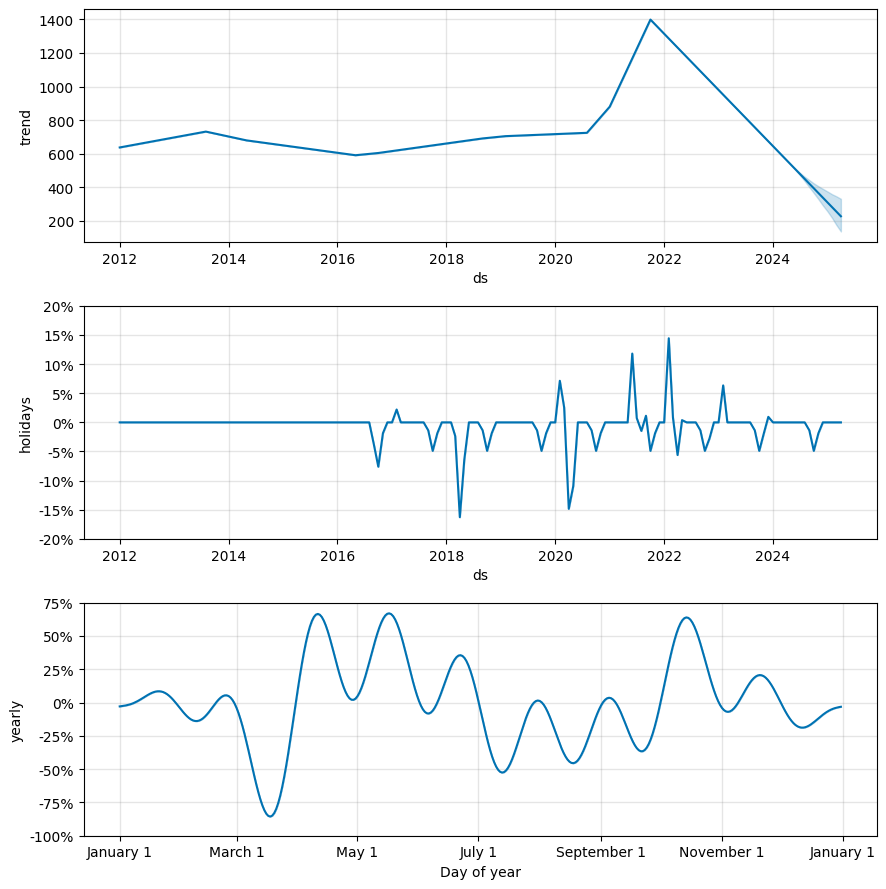

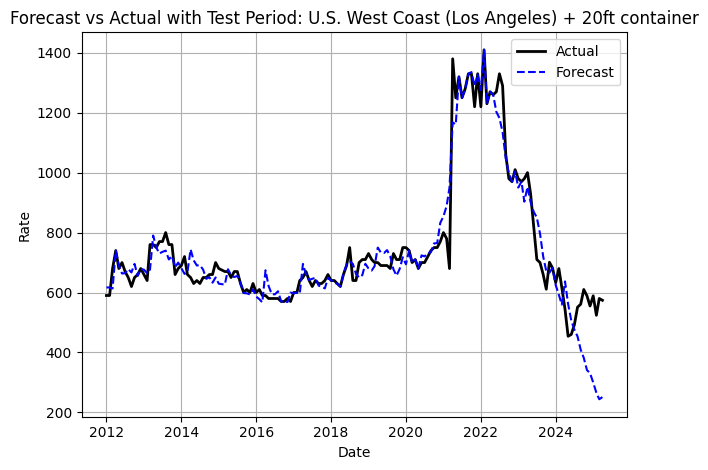


 🔴Prophet Evaluation for U.S. West Coast (Los Angeles) + 20ft container
MAE: 194.00
RMSE: 219.61


In [ ]:
forecast_1, model_1 = run_prophet_model(
    df=df,
    origin='U.S. West Coast (Los Angeles)',
    container_size='20ft container',
    events_df=events
)


In [ ]:
# When log transfomration was applied
# Prophet Evaluation for U.S. West Coast (Los Angeles) + 20ft container
# MAE: 479.51
# RMSE: 482.75

<ipython-input-6-62152dc2e1d5>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sub['Date'] = pd.to_datetime(df_sub['Date'], errors='coerce')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/yyj06av8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/e47c5co9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95150', 'data', 'file=/tmp/tmp_fjglatn/yyj06av8.json', 'init=/tmp/tmp_fjglatn/e47c5co9.json', 'output', 'file=/tmp/tmp_fjglatn/prophet_model860orikv/prophet_model-20250522142938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processin

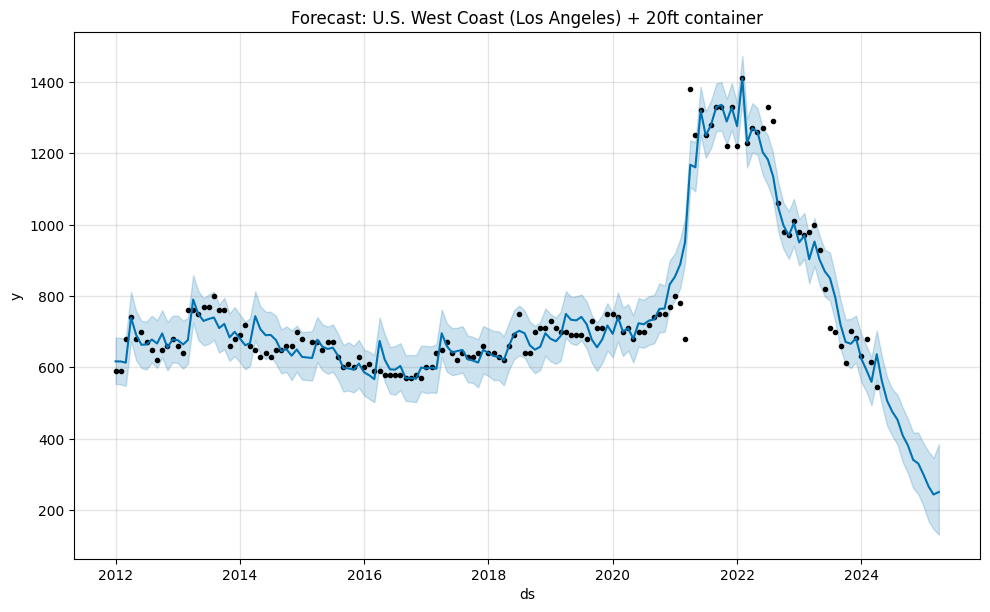

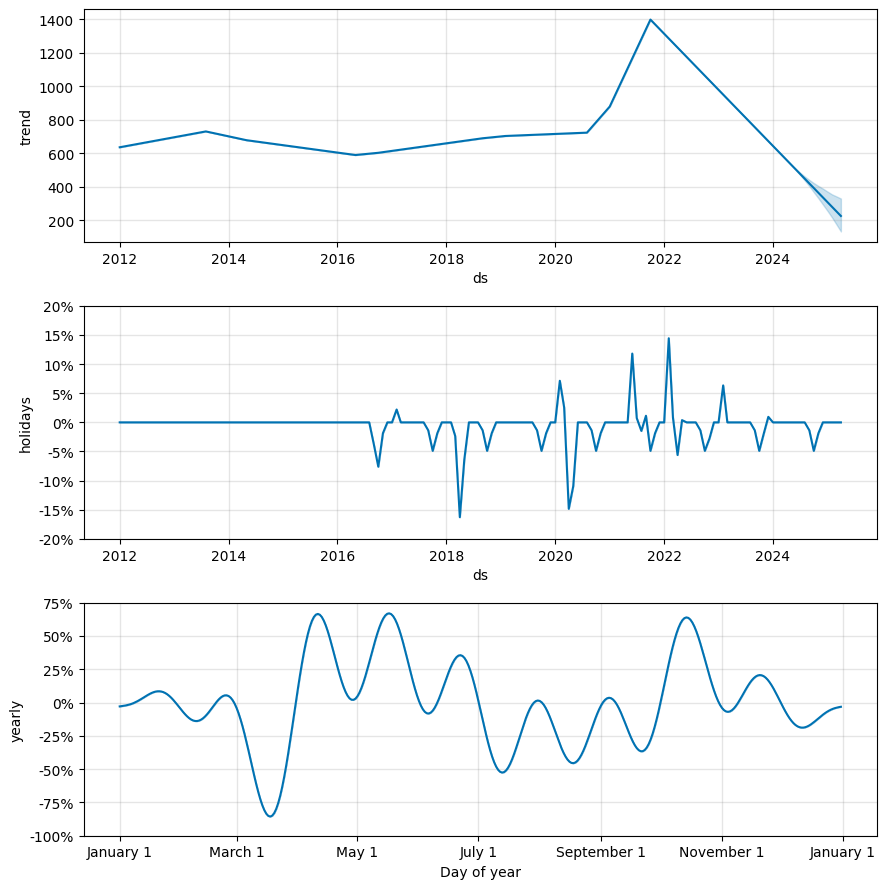

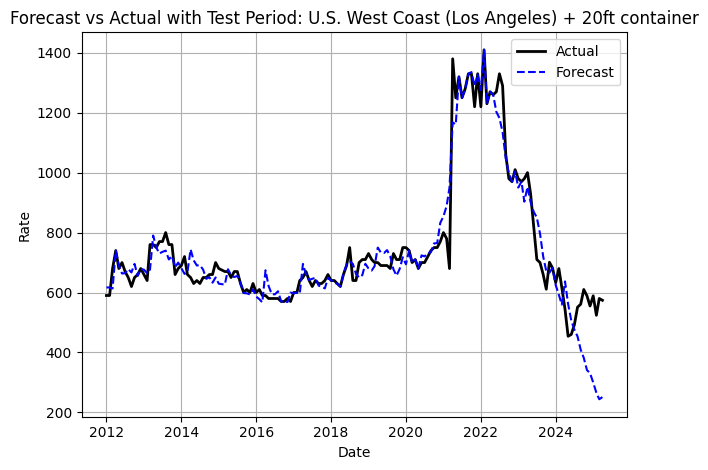


 🔴Prophet Evaluation for U.S. West Coast (Los Angeles) + 20ft container
MAE: 194.00
RMSE: 219.61


<ipython-input-6-62152dc2e1d5>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sub['Date'] = pd.to_datetime(df_sub['Date'], errors='coerce')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/p_blq94y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/m4q2fvb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36193', 'data', 'file=/tmp/tmp_fjglatn/p_blq94y.json', 'init=/tmp/tmp_fjglatn/m4q2fvb8.json', 'output', 'file=/tmp/tmp_fjglatn/prophet_modelbu9h3b6r/prophet_model-20250522142940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:40 - cmdstanpy - INFO - Chain [1] done processin

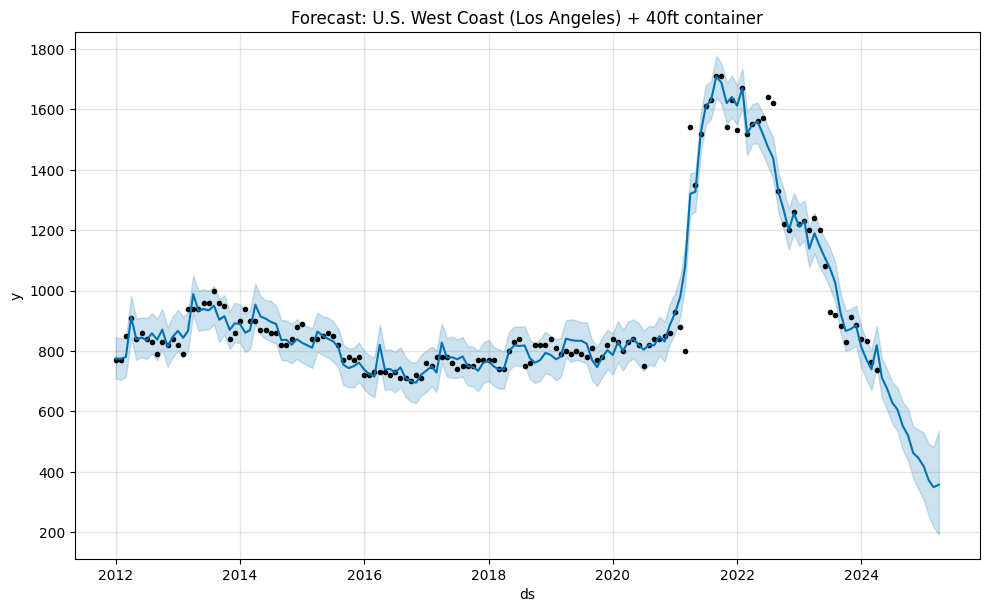

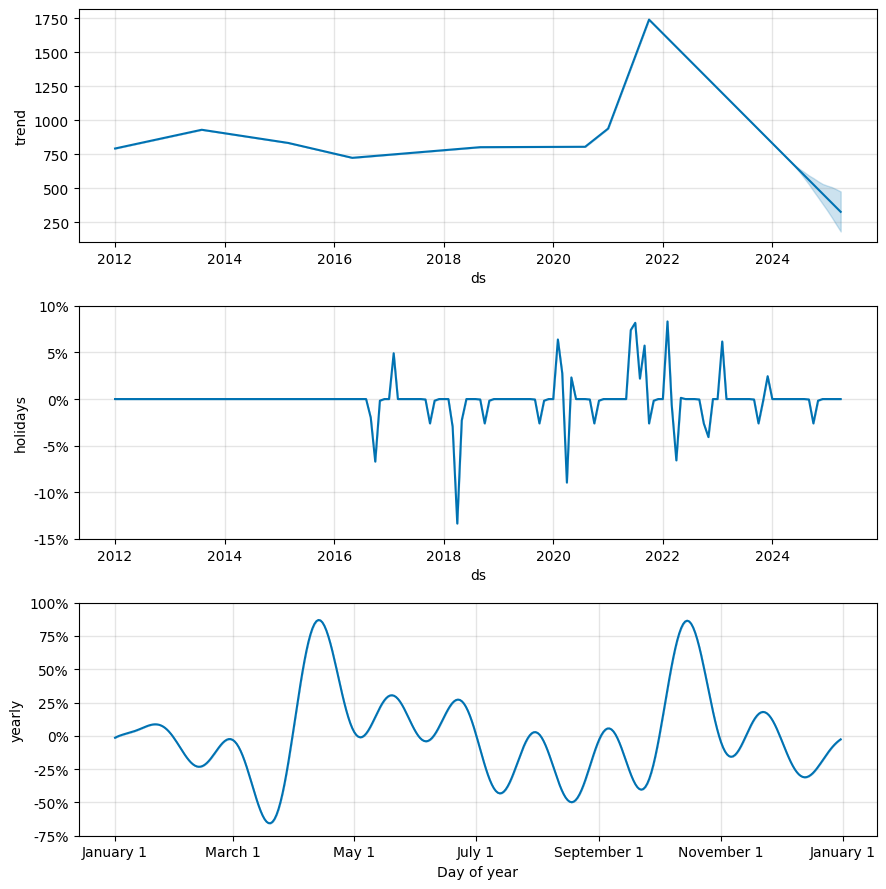

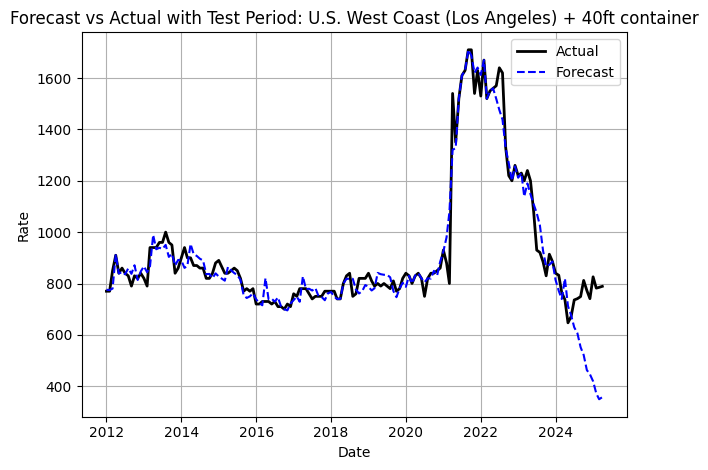

<ipython-input-6-62152dc2e1d5>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sub['Date'] = pd.to_datetime(df_sub['Date'], errors='coerce')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/551qici7.json



 🔴Prophet Evaluation for U.S. West Coast (Los Angeles) + 40ft container
MAE: 257.07
RMSE: 295.63


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/hxylqb2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11016', 'data', 'file=/tmp/tmp_fjglatn/551qici7.json', 'init=/tmp/tmp_fjglatn/hxylqb2z.json', 'output', 'file=/tmp/tmp_fjglatn/prophet_modelc_pcphxh/prophet_model-20250522142943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


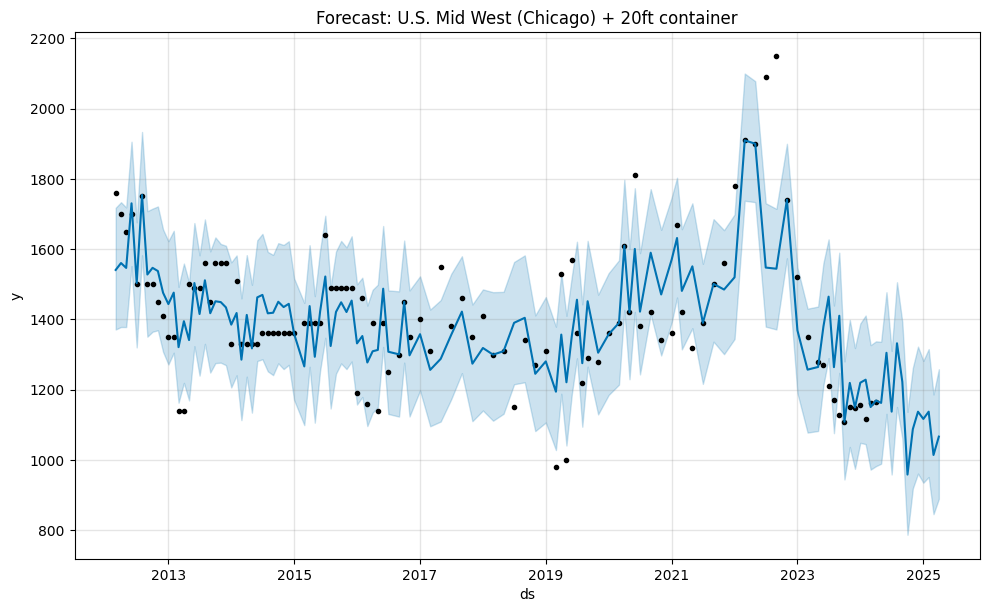

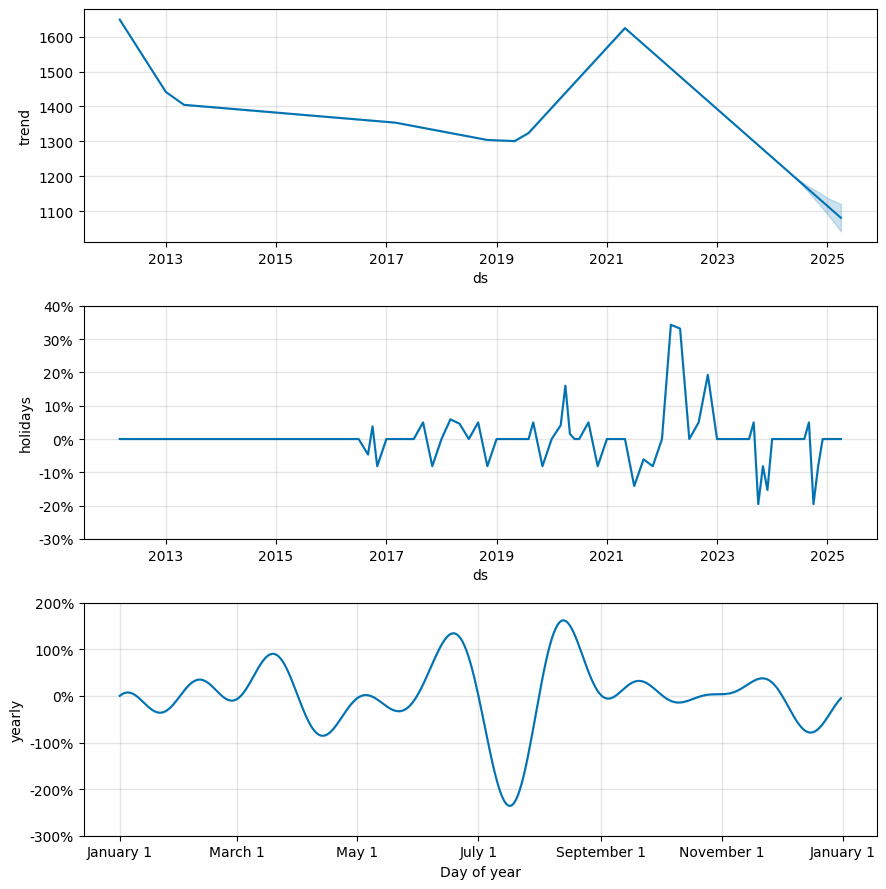

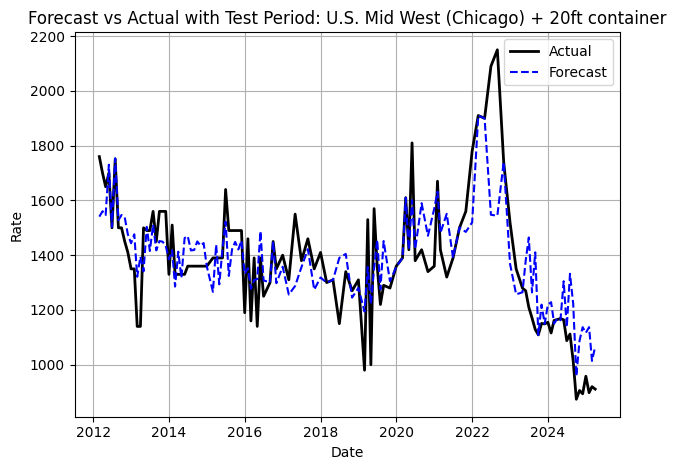

<ipython-input-6-62152dc2e1d5>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sub['Date'] = pd.to_datetime(df_sub['Date'], errors='coerce')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/u3bifg0j.json



 🔴Prophet Evaluation for U.S. Mid West (Chicago) + 20ft container
MAE: 148.57
RMSE: 165.64


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_fjglatn/y5yos4rl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68044', 'data', 'file=/tmp/tmp_fjglatn/u3bifg0j.json', 'init=/tmp/tmp_fjglatn/y5yos4rl.json', 'output', 'file=/tmp/tmp_fjglatn/prophet_modelawsf4bq5/prophet_model-20250522142945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


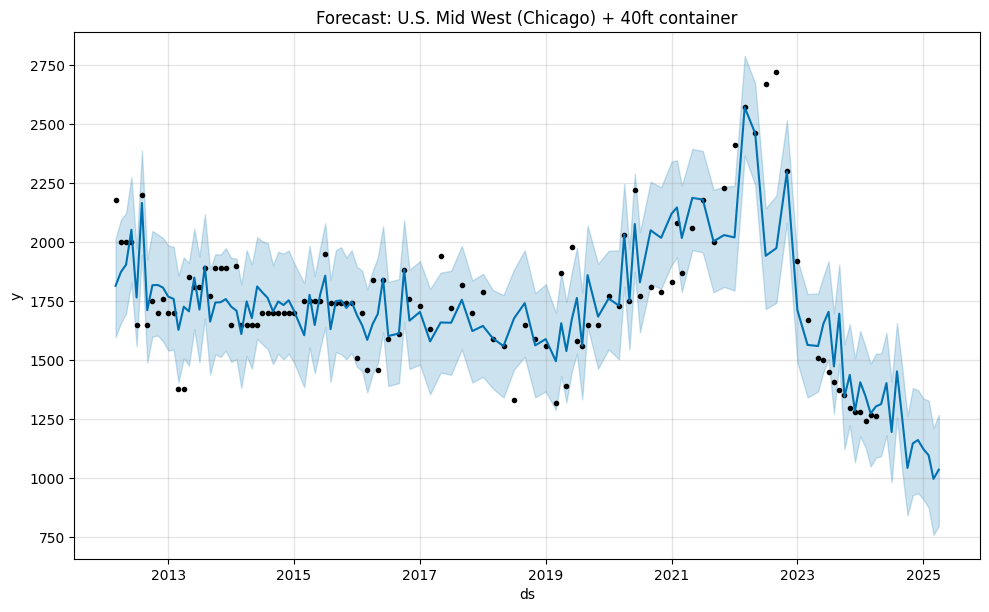

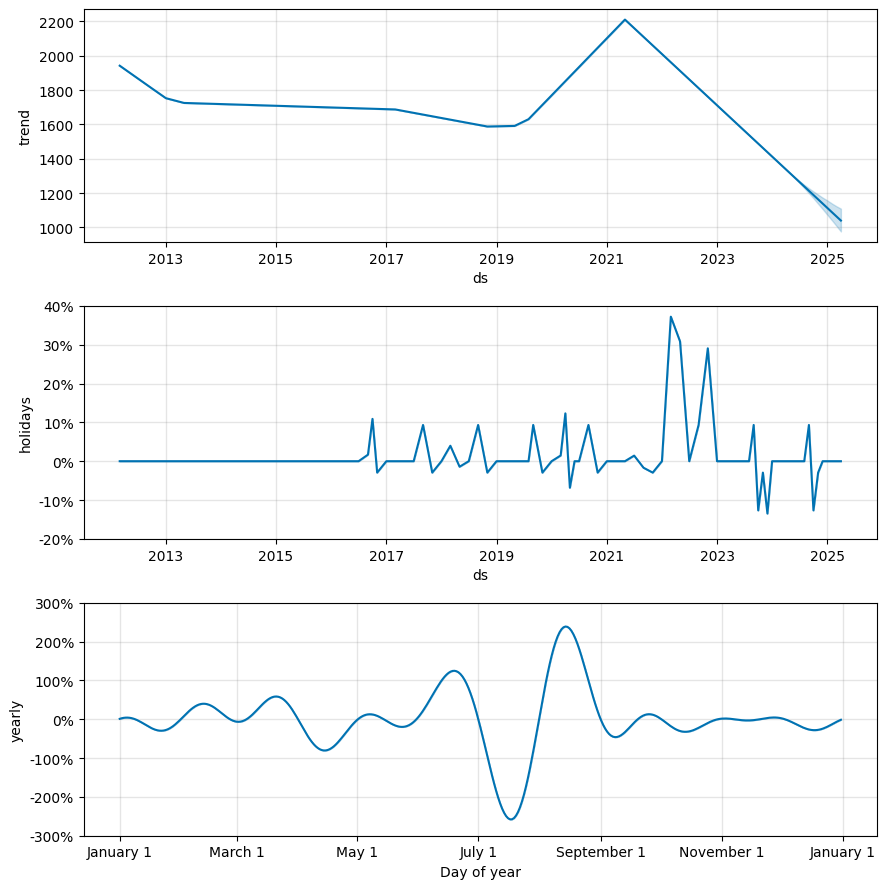

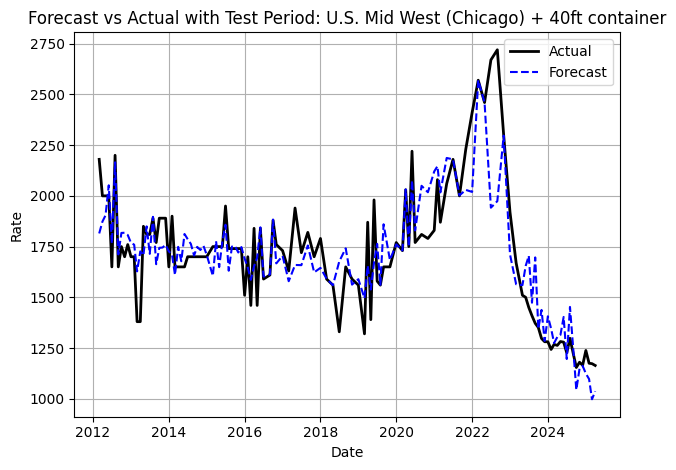


 🔴Prophet Evaluation for U.S. Mid West (Chicago) + 40ft container
MAE: 83.88
RMSE: 100.46


In [ ]:
for origin in df['Origin'].unique():
    for container in df['Container Size'].unique():
        run_prophet_model(df, origin, container, events_df=events)


In [ ]:
df['Rate'].mean()

np.float64(1140.1329787234042)

In [ ]:
filtered_df = df[
    (df['Container Size'] == '20ft container')
]

mean_rate = filtered_df['Rate'].mean()
print("Mean Rate for 20ft container from Los Angeles:", mean_rate)


Mean Rate for 20ft container from Los Angeles: 1018.3333333333334


In [ ]:
filtered_df = df[
    (df['Container Size'] == '40ft container')
]

mean_rate = filtered_df['Rate'].mean()
print("Mean Rate for 40ft container from Los Angeles:", mean_rate)


Mean Rate for 40ft container from Los Angeles: 1261.9326241134752
